In [ ]:
 import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

from IPython.display import Image

%matplotlib inline

In [ ]:
!pip install rembg
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.9 MB/s eta 0:00:00


In [ ]:
import rembg
import numpy as np
from PIL import Image

# Por diferencia de volumen según el umbral

Al principio he intentado sacar el contorno del pan mediante umbralización, pero es muy imprecisa, al final no he llegado a ningún lado con este metodo, pero lo he dejado en el colab porque me parece interesante, además, si finalmente no llego a ningún lado con el segundo metodo intentaré continuar con este

In [ ]:
img_before = cv2.imread("pan1.jpg")
img_after = cv2.imread("pan2.jpg")

# Convertir a RGB para mostrarlas correctamente en matplotlib
img_before_rgb = cv2.cvtColor(img_before, cv2.COLOR_BGR2RGB)
img_after_rgb = cv2.cvtColor(img_after, cv2.COLOR_BGR2RGB)

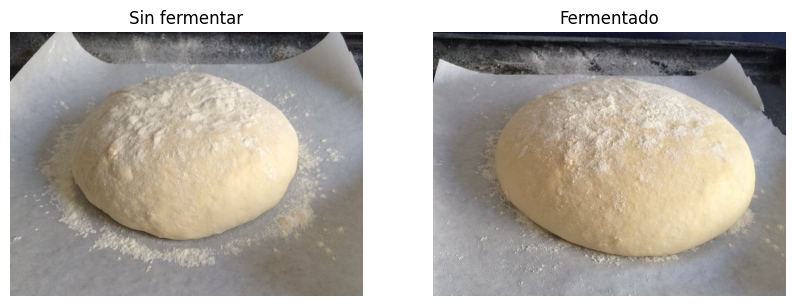

In [ ]:
# Mostrar las imágenes en paralelo
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_before_rgb)
plt.title("Sin fermentar")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_after_rgb)
plt.title("Fermentado")
plt.axis("off")

plt.show()

In [ ]:
# Convertir a escala de grises
gray_before = cv2.cvtColor(img_before, cv2.COLOR_BGR2GRAY)
gray_after = cv2.cvtColor(img_after, cv2.COLOR_BGR2GRAY)

# Aplicar umbralización
_, thresh_before = cv2.threshold(gray_before, 160, 255, cv2.THRESH_BINARY)
_, thresh_after = cv2.threshold(gray_after, 160, 255, cv2.THRESH_BINARY)

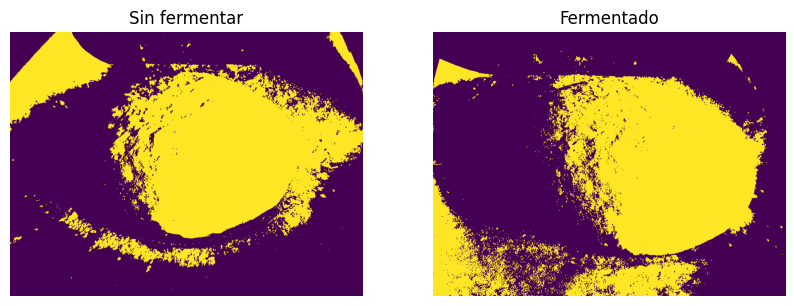

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(thresh_before)
plt.title("Sin fermentar")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(thresh_after)
plt.title("Fermentado")
plt.axis("off")

plt.show()

array([[[ 18,  22,  34],
        [ 19,  23,  35],
        [ 19,  23,  35],
        ...,
        [ 33,  44,  74],
        [ 32,  43,  73],
        [ 31,  42,  72]],

       [[ 19,  23,  35],
        [ 20,  24,  36],
        [ 22,  26,  38],
        ...,
        [ 31,  42,  72],
        [ 31,  42,  72],
        [ 30,  41,  71]],

       [[ 19,  21,  33],
        [ 22,  24,  36],
        [ 25,  27,  39],
        ...,
        [ 30,  41,  71],
        [ 30,  41,  71],
        [ 31,  42,  72]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [181, 182, 186],
        ...,
        [129, 126, 121],
        [129, 126, 121],
        [128, 125, 120]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [129, 126, 121],
        [129, 126, 121],
        [129, 126, 121]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [128, 124, 121],
        [129, 125, 122],
        [130, 126, 123]]], dtype=uint8)
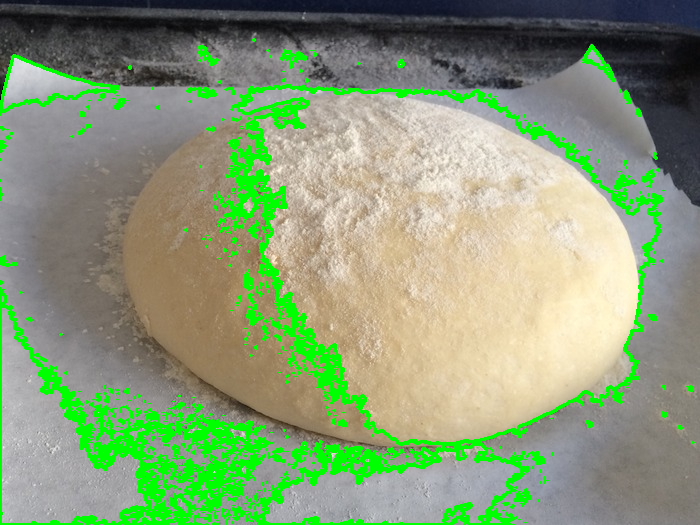

In [ ]:
# Encontrar contornos
contours_before, _ = cv2.findContours(thresh_before, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_after, _ = cv2.findContours(thresh_after, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dibujar los contornos sobre las imágenes originales
img_before_contour = img_before_rgb.copy()
img_after_contour = img_after_rgb.copy()

cv2.drawContours(img_before_contour, contours_before, -1, (0,255,0), 2)
cv2.drawContours(img_after_contour, contours_after, -1, (0,255,0), 2)

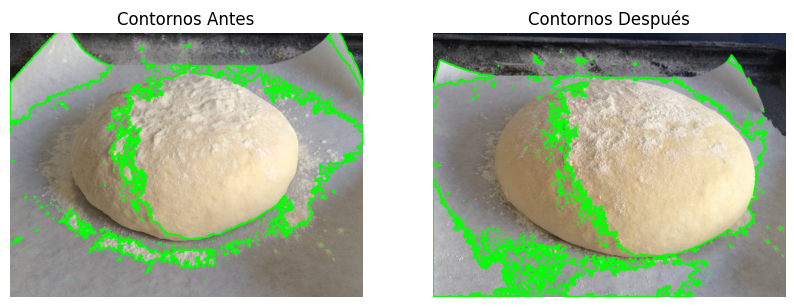

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_before_contour)
plt.title("Contornos Antes")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_after_contour)
plt.title("Contornos Después")
plt.axis("off")

plt.show()

# Por diferencia de volumen según un Elipsoide

Usando la librería rembg https://github.com/danielgatis/rembg he quitado el fondo de la imagen para tratar solo lo que nos interesa en este caso que es el pan

In [ ]:
def remove_background(image_path):
  # Load the input image
  input_image = Image.open(image_path)

  # Convert the input image to a numpy array
  input_array = np.array(input_image)

  # Apply background removal using rembg
  output_array = rembg.remove(input_array)

  # Create a PIL Image from the output array
  output_image = Image.fromarray(output_array)

  # Convert the image to RGB mode before saving
  output_image = output_image.convert("RGB")

  # Save the output image
  #output_image.save('output_image.jpg')

  return output_image

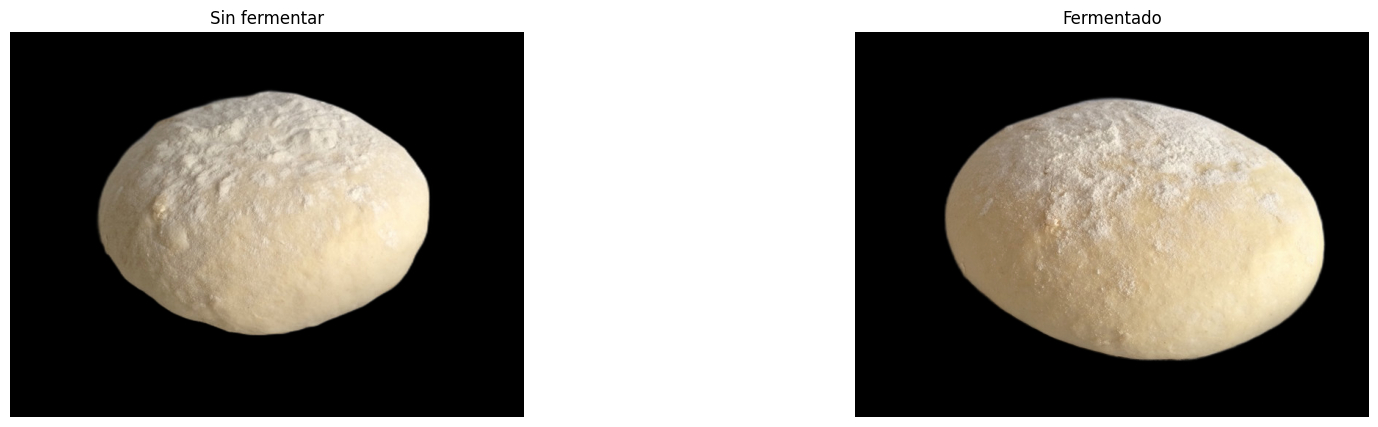

In [ ]:
bread1 = remove_background('pan1.jpg')
bread2 = remove_background('pan2.jpg')

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.imshow(bread1)
plt.title("Sin fermentar")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(bread2)
plt.title("Fermentado")
plt.axis("off")

plt.show()

Podemos considerar las masas casi como elipsoides partidos por la mitad
Por lo que podemos calcular el contorno del pan mediante el volumen del elipsoide

In [ ]:
def estimate_volume(image):
    # Convertir la imagen PIL a array de OpenCV
    image_cv = np.array(image)

    # Convertir a escala de grises y aplicar umbralización
    gray = cv2.cvtColor(image_cv, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    # Encontrar contornos
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Seleccionar el contorno más grande
    if len(contours) == 0:
        return 0, None  # Si no encuentra contornos, retorna volumen 0

    largest_contour = max(contours, key=cv2.contourArea)

    # Ajustar una elipse al contorno
    if len(largest_contour) < 5:
        return 0, None  # Se necesitan al menos 5 puntos para fitEllipse

    ellipse = cv2.fitEllipse(largest_contour)
    (x, y), (major_axis, minor_axis), angle = ellipse  # Extraer parámetros de la elipse

    # Estimar el volumen del elipsoide (asumiendo que la altura es 0.6 * eje mayor)
    c = 0.6 * major_axis
    volume = ((4/3) * np.pi * (major_axis/2) * (minor_axis/2) * (c/2))*0.5

    return volume, ellipse

In [ ]:
vol1, ellipse1 = estimate_volume(bread1)
vol2, ellipse2 = estimate_volume(bread2)

In [ ]:
# Calcular la diferencia de volumen
vol_diff = vol2 - vol1
percentage_change = (vol_diff / vol1) * 100 if vol1 != 0 else 0

# Mostrar resultados
print(f"Volumen Antes: {vol1:.2f} unidades cúbicas")
print(f"Volumen Después: {vol2:.2f} unidades cúbicas")
print(f"Diferencia de Volumen: {vol_diff:.2f} unidades cúbicas ({percentage_change:.2f}%)")

Volumen Antes: 7464954.14 unidades cúbicas
Volumen Después: 9924547.12 unidades cúbicas
Diferencia de Volumen: 2459592.98 unidades cúbicas (32.95%)


Reglas Generales para la Fermentación del Pan
Duplicación del Volumen (Aumento del 80%-100%)

En la mayoría de los panes, la masa debe crecer 1.8x a 2x su volumen inicial antes de hornear.
Esto asegura una estructura adecuada y buena esponjosidad después del horneado.
Ejemplo: Si la masa inicial tiene 300 cm³, debería alcanzar entre 540 cm³ y 600 cm³ antes de hornear.
Sobrefermentación (>2.5x su volumen inicial)

Si la masa crece más de 2.5 veces su volumen inicial, la estructura puede colapsar durante el horneado.
Se vuelve pegajosa, débil y puede hundirse en el centro.
Fermentación Insuficiente (<1.5x su volumen inicial)

Si la masa no alcanza al menos 1.5 veces su volumen inicial, el pan será denso y poco aireado.

In [ ]:
if 1.8 * vol1 <= vol2 <= 2.2 * vol1:
    print("La fermentación es adecuada, la masa está lista para hornear.")
elif vol2 > 2.5 * vol1:
    print("¡Cuidado! La masa está sobrefermentada.")
elif vol2 < 1.5 * vol1:
    print("La fermentación es insuficiente, necesita más tiempo.")
else:
    print("La masa puede estar lista, pero revisa su estructura manualmente.")

La fermentación es insuficiente, necesita más tiempo.


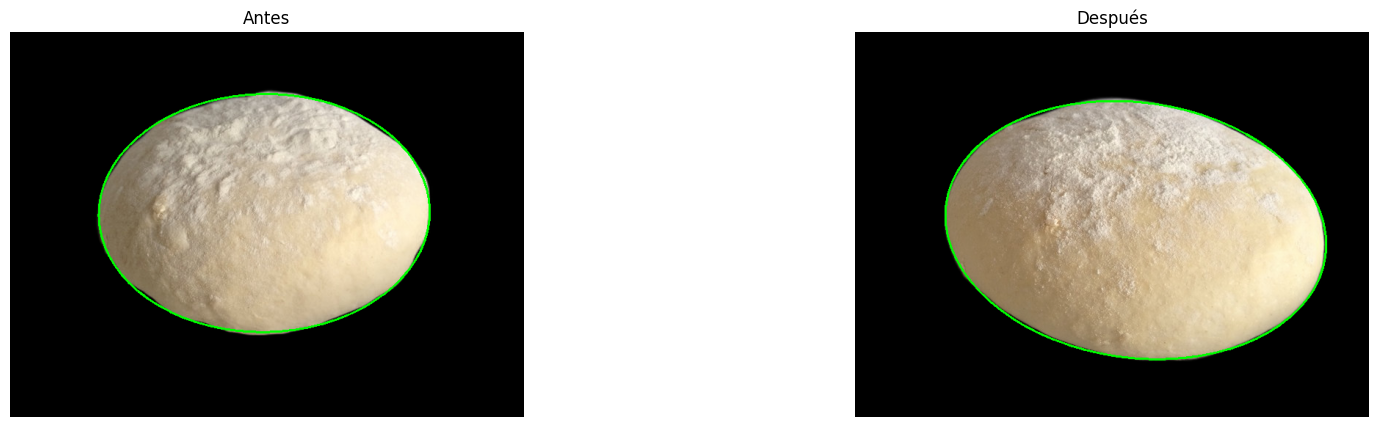

In [ ]:
# Visualizar las imágenes con la elipse ajustada
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

for ax, img, ellipse, title in zip(axes, [bread1, bread2], [ellipse1, ellipse2], ["Antes", "Después"]):
    img_cv = np.array(img)
    if ellipse:
        cv2.ellipse(img_cv, ellipse, (0,255,0), 2)

    ax.imshow(img_cv)
    ax.set_title(title)
    ax.axis("off")

plt.show()

# Por diferencia de altura según el contorno

Como vemos, nuestro modelo según el volumen no es del todo bueno. Nos indica un porcentaje que no es el real respecto a las dos imagenes proporcionadas. Las cuales la segunda si esta lista para hornear. Quiza la diferencia de volumen en la imagen no es la suficiente para el modelo, pero creo que la técnica utilizada es bastante buena. Probablemente si tuvieramos un angulo distinto se podría medir con la diferencia de un volumen distinto o si tuvieramos un objeto de referencia para el modelo la medición podría llegar a ser más precisa.

He intentado calcular la diferencia mediante la diferencia de altura de los contornos, ya que al fin y al cabo, el contorno sigue siendo un objeto en 2 dimensiones pero tampoco a dado mucho resultado.

In [ ]:
def estimate_height_from_area(image_path):
    """
    Estima la altura del pan a partir del área de la silueta y el eje mayor de la elipse ajustada.
    """
    # Cargar imagen en escala de grises
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Aplicar umbralización para obtener el contorno
    _, thresh = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)

    # Encontrar contornos
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Seleccionar el contorno más grande (suponiendo que es el pan)
    largest_contour = max(contours, key=cv2.contourArea)

    # Calcular área de la silueta
    area = cv2.contourArea(largest_contour)

    # Ajustar una elipse al contorno del pan
    ellipse = cv2.fitEllipse(largest_contour)
    major_axis = max(ellipse[1])  # Eje mayor de la elipse

    # Estimar la altura usando la fórmula c = A / a
    estimated_height = area / major_axis

    return estimated_height

In [ ]:
height_before = estimate_height_from_area("pan1.jpg")
height_after = estimate_height_from_area("pan2.jpg")

In [ ]:
print(f"Altura estimada antes de la fermentación: {height_before:.2f} píxeles")
print(f"Altura estimada después de la fermentación: {height_after:.2f} píxeles")

# Mostrar la diferencia
height_difference = height_after - height_before
print(f"Diferencia de altura: {height_difference:.2f} píxeles")

Altura estimada antes de la fermentación: 240.77 píxeles
Altura estimada después de la fermentación: 288.30 píxeles
Diferencia de altura: 47.53 píxeles


In [ ]:
if 1.8 * height_before <= height_after <= 2.2 * height_before:
    print("La fermentación es adecuada, la masa está lista para hornear.")
elif height_after > 2.5 * height_before:
    print("¡Cuidado! La masa está sobrefermentada.")
elif height_after < 1.5 * height_before:
    print("La fermentación es insuficiente, necesita más tiempo.")
else:
    print("La masa puede estar lista, pero revisa su estructura manualmente.")

La fermentación es insuficiente, necesita más tiempo.
